In [2]:
from pathlib import Path
import typing as T
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy
import xarray as xr
import iris
import iris.plot
import numpy as np
import os
import textwrap
import itertools
#import ants
import warnings

In [3]:
home_dir=os.environ['HOME']
HOME=Path(home_dir)

In [4]:
# Find all regions for a given rose-id
ROSE ='u-dv602'
REGION_DIRS = [ d for d in list((HOME / 'cylc-run' / ROSE / 'share/data/ancils/' ).glob('*')) if d.is_dir() ]
REGION_DIRS                                                           

[PosixPath('/home/548/pag548/cylc-run/u-dv602/share/data/ancils/Test_Ocean')]

In [5]:
# Find all resolutions for a given REGION
for r_dir in REGION_DIRS:
    RESOLUTION_DIRS = [ d for d in list((r_dir).glob('*')) if d.is_dir() ]

In [6]:
RESOLUTION_DIRS

[PosixPath('/home/548/pag548/cylc-run/u-dv602/share/data/ancils/Test_Ocean/era5'),
 PosixPath('/home/548/pag548/cylc-run/u-dv602/share/data/ancils/Test_Ocean/test')]

Plotting land_binary_mask for era5


/g/data/xp65/public/apps/med_conda/envs/analysis3-25.10/lib/python3.11/site-packages/distributed/diagnostics/nvml.py:14: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml


Plotting land_binary_mask for test


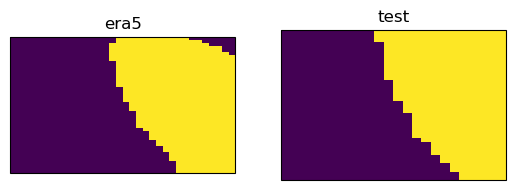

In [7]:
# quick check - plot and store land-sea masks for these resolutions
# Ignore warnings from mule  and iris 
warnings.filterwarnings('ignore',module='mule') 
warnings.filterwarnings('ignore',module='iris') 

num_plots = len(RESOLUTION_DIRS)

lsm_masks = {}

fig,ax = plt.subplots(1,num_plots,subplot_kw={'projection': ccrs.PlateCarree()})

for i,R in enumerate(RESOLUTION_DIRS):
    MASK_FILE = R / 'qrparm.mask'
    #mask_cubes = ants.load(MASK_FILE)
    mask_cubes = iris.load(MASK_FILE)

    # Select the cube corresponding to 'land_binary_mask'
    lbm_cube, = [ cube for cube in mask_cubes if cube.name() == 'land_binary_mask'] 
    print (f'Plotting land_binary_mask for {R.name}')
    
    iris.plot.pcolormesh(lbm_cube,axes=ax[i])
    ax[i].set_title(f'{R.name}')

    # Store the masks for later analysis
    lsm_masks[R.name] = xr.DataArray.from_iris(lbm_cube)

In [8]:
# Now create dictionaries for all ancillary parameter files for each resolution
parm_files = {}

for i,R in enumerate(RESOLUTION_DIRS):
    
    all_files = list(R.glob('qrparm*'))

    # Filter out symlinks
    files = []
    [ files.append(f) for f in all_files if not f.is_symlink() ]

    parm_files[R.name] = files

In [9]:
# Get total list of fields for each resolution
num_plots = {}

# Loop over LAM resolutions
for res in parm_files.keys():

    count = 0
    # Loop over each ancillary parameter file for this resolution
    for file in parm_files[res]:
        #print (f'INFO : Loading {file}')
        try:
            #cube = ants.load(file)
            cube = iris.load(file)
            #print (cube)
            count += len(cube)
        except:
            print (f'ERROR : Unable to open {file}\nERROR : You will have to manually check this file using "xconv" ')
            continue

    num_plots[res] = count
    print (f'There are {num_plots[res]} fields for {res}')
    

ERROR : Unable to open /home/548/pag548/cylc-run/u-dv602/share/data/ancils/Test_Ocean/era5/qrparm.veg.dist
ERROR : You will have to manually check this file using "xconv" 
There are 71 fields for era5
ERROR : Unable to open /home/548/pag548/cylc-run/u-dv602/share/data/ancils/Test_Ocean/test/qrparm.veg.dist
ERROR : You will have to manually check this file using "xconv" 
There are 71 fields for test


In [10]:
# Some logic to collapse multi-level cubes for simple plotting. It is assumed that any gross
# errors in the ancillaries (e.g. NaNs) will remain after the averaging

def collapse_cube(file,
                  cube):
    """
    Collapse a cube onto lat/lon dimensions via averaging
    """
    collapse_dims = []
    
    for coord in cube.coords():
        if coord not in cube.dim_coords:
            collapse_dims.append(coord.name())
            print (f'For {file.name} {cube.name()} coordinate {coord.name()} will be collapsed')
            
    # Check if time remains
    if 'time' in [ c.name() for c in cube.dim_coords ]: 
        collapse_dims.append('time')
        print (f'For {file.name} variable {cube.name()} coordinate time will be collapsed')
    new_cube = cube.collapsed(collapse_dims,iris.analysis.MEAN)

    return new_cube

In [11]:
# These ancillaries have a land-sea mask (i.e. ocean regions are already full of NaNs)
land_file_types = ['soil', 'veg', 'hydtop','MORUSES' ] 

In [12]:
# Set up diagnostic plotting for each resolution

def plot_ancils(region,
                files,
                num_plots,
                plot=True,
                num_columns=4,
                lat_range=[],
                lon_range=[],
                ):
    """
    Plot ancillaries fields for a given LAM resolution
    Check for the existence of NaNs and return these fields as a list
    of data_arrays
    """

    nan_fields = []
    
    num_rows = num_plots // num_columns
    
    if num_plots % num_columns != 0:
        num_rows += 1
    
    Position = range(1,num_plots+1)
    
    fig_height = num_rows*3
    fig_width = 15
    max_label_length=30

    print (f' Plotting ancillary parameters for {region}\n')
    
    fig = plt.figure(figsize=(fig_width,fig_height))
    k = 0
    
    # Loop over all ancillary files
    
    for file in files:
        try:
            #cubes = ants.load(file)
            cubes = iris.load(file)
        except:
            print (f'ERROR : Unable to open {file}')
            continue
    
        # Loop over all variables in cube
        for cube in cubes:
            ax = fig.add_subplot(num_rows, num_columns, Position[k])
    
            if len(cube.shape) > 2: 
                # Need to reduce dimension
                cube = collapse_cube(file,cube)
                
            da = xr.DataArray.from_iris(cube)
    
            # Find NaNs
            all_mask = da.isnull()
            
            # Check if this ancillary already has a land-sea mask
            if any(t in str(file) for t in land_file_types):
                # Remove the ocean from the NaN search
                all_mask = lsm_masks[region] & da.isnull()
        
            if all_mask.compute().sum() > 0:   
                print (f'ERROR : NaNs identified in {cube.name()},{file.name}')
                nan_fields.append(da)
            
            if 'standard_name' in da.attrs.keys():
                split = textwrap.wrap(da.attrs['standard_name'].replace('_',' '),max_label_length)
                label = '\n'.join(split)
                cb_args = {'label': label}
            else:
                cb_args = {'label':da.attrs['STASH']}

            # Plot according to specified lat/lon ranges
            if lat_range and lon_range:
                da.sel(latitude=slice(lat_range[0],lat_range[1]),
                       longitude=slice(lon_range[0],lon_range[1]))\
                       .plot(ax=ax,cbar_kwargs=cb_args)
            elif lat_range:
                da.sel(latitude=slice(lat_range[0],lat_range[1]))\
                       .plot(ax=ax,cbar_kwargs=cb_args)
            elif lon_range:
                da.sel(longitude=slice(lon_range[0],lon_range[1]))\
                       .plot(ax=ax,cbar_kwargs=cb_args)
            else:
                da.plot(ax=ax,cbar_kwargs=cb_args)
            ax.set_title(file.name)
            k += 1

    fig.suptitle(f'Ancillary parameter fields for {region}',fontsize=20,y=1.0)
    plt.tight_layout()

    return nan_fields

 Plotting ancillary parameters for test

For qrparm.veg.func_igbp canopy_height coordinate forecast_period will be collapsed
For qrparm.veg.func_igbp canopy_height coordinate month will be collapsed


/jobfs/157230704.gadi-pbs/ipykernel_3533865/3811585045.py:53: FutureWarning: In a future version, xarray will not decode the variable 'forecast_period' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  da = xr.DataArray.from_iris(cube)


AttributeError: Rectangle.set() got an unexpected keyword argument 'cbar_kwargs'

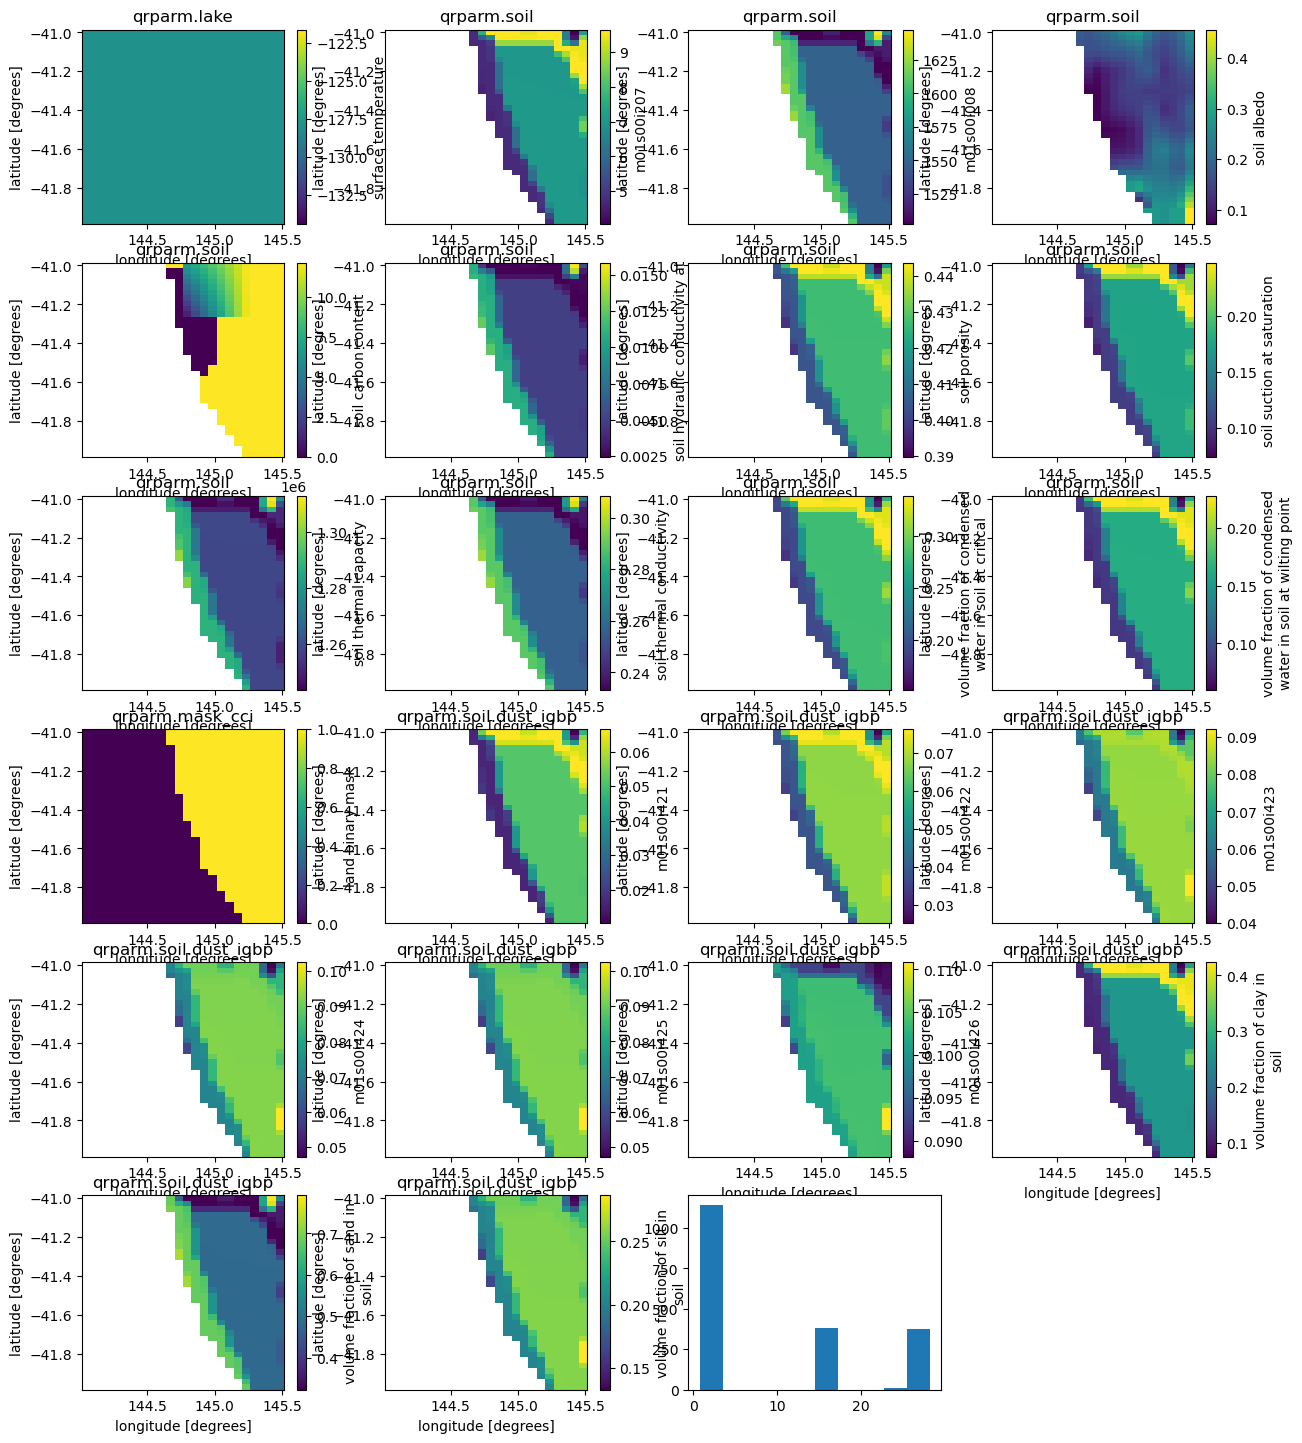

In [15]:
# Now plot for all resolutions and catch ancillary parameter fields with NaNs
bad_ancils = []

# Loop over all resolutions
#for res in parm_files.keys():
for res in ['test']:
    nan_ancils = plot_ancils(res,
                             parm_files[res],
                             num_plots[res])

    bad_ancils.extend(nan_ancils)

In [ ]:
# Now plot the bad_ancils
num_plot=len(bad_ancils)
num_columns=3
num_rows = num_plot // num_columns

if num_plot % num_columns != 0:
    num_rows += 1

Position = range(1,num_plot+1)

fig_height = num_rows*3
fig_width = 15
max_label_length=30

fig = plt.figure(figsize=(fig_width,fig_height))

k = 0

for k in range(num_plot):
     ax = fig.add_subplot(num_rows, num_columns, Position[k])
     da = bad_ancils[k]
     da.plot(ax=ax)
     ax.set_title(f'{da.name}')
plt.tight_layout()

In [ ]:
# Zoom in on NaNs. Let's do this manually for region era5
# These ancils have a land-sea mask so we need to extract that
da = bad_ancils[0]
mask = lsm_masks['era5']

all_mask = mask & da.isnull()

# Find location of NaNs
all_mask.compute()
all_mask.where(all_mask.compute()==True,drop=True).compute()

In [ ]:
# OK, so we seem to have three points of NaN located b/w lat -54.7 to -52.6
# lat 158.9 to 169.2
da.sel(latitude=slice(-55,-45),longitude=slice(158,170)).plot()


In [ ]:
# So we are in the Southern Ocean. Let's plot the bad points
points = all_mask.where(all_mask.compute()==True,drop=True).compute()

In [ ]:
all_mask.sel(latitude=slice(-55,-45),longitude=slice(158,170)).plot()

In [ ]:
# These points appear to be associated with Macquarie Island and Campbell Island.
# Let's plot all the ERA5 ancillaries around Macquarie Island.
all_mask.sel(latitude=slice(-55,-54),longitude=slice(158,159)).plot()

In [ ]:
res='era5'
nan_ancils = plot_ancils(res,
                         parm_files[res],
                         num_plots[res],
                         lat_range=[-55,-54],
                         lon_range=[158,159])

In [ ]:
# Repeat for Cambpell Island
all_mask.sel(latitude=slice(-53,-52),longitude=slice(168.5,169.5)).plot()

In [ ]:
res='era5'
nan_ancils = plot_ancils(res,
                         parm_files[res],
                         num_plots[res],
                         lat_range=[-53,-52],
                         lon_range=[168.5,169.5])

In [ ]:
# Same issue for Macquarie Island - the canopy height fields are missing

In [ ]:
# OK. So Macquarie Island is resolved at this resolution for all ancillaries except canopy height.
#  And the island is resolved by qrparm.mask_cci (which is the file used by the UM).
#  The island isn't resolved by qrparm.mask_sea however.
# Let's use the method suggested by Matthew Lipson : https://forum.access-hive.org.au/t/aus2200-vegetation-fraction-ancil-creation-issues/1972/13?u=paul.gregory
veg_func_file, = [ f for f in parm_files['era5'] if f.name == 'qrparm.veg.func' ]
lsm_mask_file,  = [ f for f in parm_files['era5'] if f.name == 'qrparm.mask_cci' ]

In [ ]:
veg_cube = ants.load(veg_func_file)[0]
lsm_cube = ants.load(lsm_mask_file)[0]

In [ ]:
level=3
canopy_level = iris.Constraint(pseudo_level=level)

In [ ]:
veg_cube.extract(canopy_level)

In [ ]:
veg_cube.coords()

In [ ]:
# Use time constraints
# https://gist.github.com/dennissergeev/58a04be5fdfe37cedea838a19203e75e
tcoord = veg_cube.coord("time")
time_constr = iris.Constraint(time=lambda t: t.point == tcoord.units.num2date(tcoord.points[0]))
veg_slice=veg_cube.extract(time_constr).extract(canopy_level)

In [ ]:
veg_slice

In [ ]:
# Plot veg_slice around the southern ocean:
fig=plt.figure()
iris.plot.pcolormesh(veg_slice.intersection(latitude=(-55,-45),longitude=(158,170)))
plt.colorbar()

In [ ]:
veg_cube.extract(canopy_level)

In [ ]:
canopy_height = xr.DataArray.from_iris(veg_cube)
canopy_height

In [ ]:
fig,ax=plt.subplots(5,1,figsize=(5,15))

for level in canopy_height.dim_0:
    da = canopy_height.sel(dim_0=level,latitude=slice(-55,-45),longitude=slice(158,170)).\
         mean('time').plot(ax=ax.flatten()[level])
plt.tight_layout()

In [ ]:
# To do - interrrogate the master data ancillary to see if the data is missing at these levels
master_lai = Path('/home/548/pag548/cylc-run/u-dg767/share/data/etc/ancil_master_cap/vegetation/lai/modis_4km/v1/qrparm.data')
master_lai_cube, = ants.load(master_lai)
tcoord = master_lai_cube.coord("time")
time_constr = iris.Constraint(time=lambda t: t.point == tcoord.units.num2date(tcoord.points[0]))

In [ ]:
master_lai_da = xr.DataArray.from_iris(master_lai_cube)
master_lai_da[0]

In [ ]:
master_lai_da[0].plot()

In [ ]:
master_lai_da[0].sel(latitude=slice(-55+180,-45+180),longitude=slice(158,170)).plot()

In [ ]:
master_canopy = Path('/home/548/pag548/cylc-run/u-dg767/share/data/etc/ancil_master_cap/vegetation/canopy/simard/v1/Simard_Pinto_3DGlobalVeg_JGR.nc')
master_canopy_cube, = ants.load(master_canopy)
master_canopy_cube

In [ ]:
master_cover = Path('/home/548/pag548/cylc-run/u-dg767/share/data/etc/ancil_master_cap/vegetation/cover/igbp/v3/gigbp2_0ll.nc')
master_cover_cube, = ants.load(master_cover)

In [ ]:
# Repeat of u-cp146